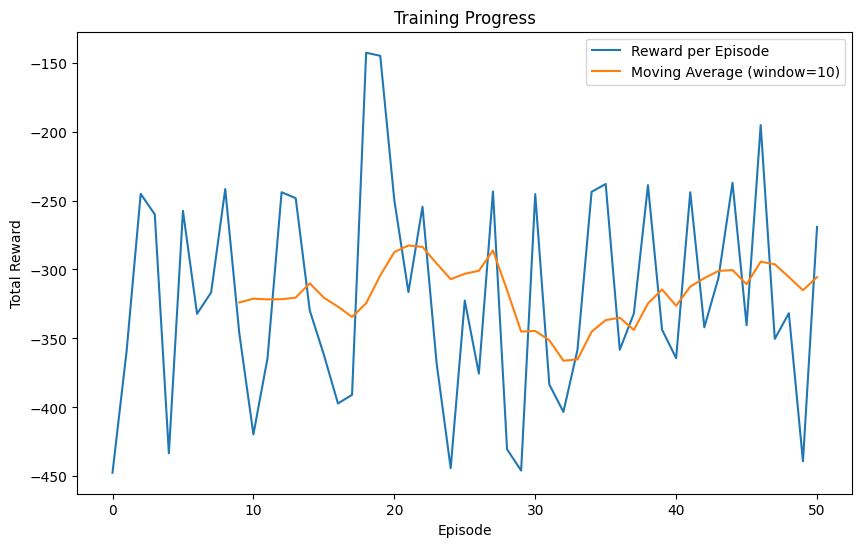

Episode: 50, Total Reward: [-269.1333]
[0] Reward: [-0.54785156], state:[0.76642174 0.6423377  0.75971895], done:False, truncated:False
1/1 [==============================] - 0s 27ms/step
[1] Reward: [-0.64752257], state:[0.76642174 0.6423377  0.75971895], done:False, truncated:False
1/1 [==============================] - 0s 24ms/step
[2] Reward: [-0.8871539], state:[0.76642174 0.6423377  0.75971895], done:False, truncated:False
1/1 [==============================] - 0s 23ms/step
[3] Reward: [-1.2213976], state:[0.76642174 0.6423377  0.75971895], done:False, truncated:False
1/1 [==============================] - 0s 23ms/step
[4] Reward: [-1.8673139], state:[0.76642174 0.6423377  0.75971895], done:False, truncated:False
1/1 [==============================] - 0s 23ms/step
[5] Reward: [-2.5371888], state:[0.76642174 0.6423377  0.75971895], done:False, truncated:False
1/1 [==============================] - 0s 24ms/step
[6] Reward: [-3.4538007], state:[0.76642174 0.6423377  0.75971895], don

: 

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Hyperparameters
learning_rate = 0.001
epsilon = 1.0  # Exploration probability at start
epsilon_min = 0.01  # Minimum exploration probability 
epsilon_decay = 0.995  # Exponential decay rate for exploration prob
gamma = 0.95  # Discounting rate

# Create the environment
env = gym.make('Pendulum-v1')

# DQN Model
def build_model():
    model = Sequential()
    model.add(Dense(24, input_shape=(3,), activation='relu'))  # Input shape = 3 for Pendulum
    model.add(Dense(48, activation='relu'))
    model.add(Dense(1, activation='tanh'))  # Action space bound [-2, 2]
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate))
    return model

# Initialize DQN and Target Network
dqn_model = build_model()
target_model = build_model()
target_model.set_weights(dqn_model.get_weights())

# Experience Replay
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        state = np.asarray(state).reshape(-1)  # Ensuring state is a 1D array
        next_state = np.asarray(next_state).reshape(-1)  # Ensuring next_state is a 1D array
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        # Choose a random action
        return env.action_space.sample()
    else:
        # Choose the best action
        q_values = dqn_model.predict(np.array([state]))
        return np.clip(q_values[0], -2.0, 2.0)  # Clip to action space limits

def update_model(batch):
    for state, action, reward, next_state, done in batch:
        # Convert state and next_state to numpy arrays
        state_array = np.array([state])
        next_state_array = np.array([next_state])

        target = reward
        if not done:
            target = (reward + gamma * np.amax(target_model.predict(next_state_array.reshape(1, -1))))
        
        target_f = dqn_model.predict(state_array.reshape(1, -1))
        target_f[0][0] = target
        dqn_model.fit(state_array.reshape(1, -1), target_f, epochs=1, verbose=0)
# def smooth_data(data, window_percent):
#     window_size = int(len(data) * window_percent)
#     window_size = max(1, window_size)
#     smoothed = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
#     return window_size, smoothed

# def plot_live(loss_log):
#     # Smooth data
#     window_size_ll, smoothed_data_ll = smooth_data(loss_log, 0.05)
#     window_size_ps, smoothed_data_ps = smooth_data(perc_score_log, 0.05)

#     # Plotting
#     clear_output(wait=True)
#     fig, axs = plt.subplots(4, 1, figsize=(12, 16))

#     # Loss Log Graph
#     axs[0].plot(loss_log, label='Original Data', linestyle='--', alpha=0.4)
#     axs[0].plot(np.arange(window_size_ll - 1, len(loss_log)), smoothed_data_ll, label='Smoothed Data')
#     axs[0].set_title("Loss Log Over Time")
#     axs[0].set_ylabel('Value')
#     axs[0].set_xlabel('Episode')
#     axs[0].grid(True)
#     axs[0].legend()
def update_graph(episode, scores, window=10):
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.title("Training Progress")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    scores = np.array(scores).flatten()  # Ensure scores is one-dimensional

    # Plot the scores
    plt.plot(scores, label='Reward per Episode')

    # Calculate and plot the moving average
    moving_avg = np.convolve(scores, np.ones(window)/window, mode='valid')
    x_axis_range = np.arange(window - 1, window - 1 + len(moving_avg))
    plt.plot(x_axis_range, moving_avg, label=f'Moving Average (window={window})')
    plt.legend()
    plt.show(block=False)
    plt.pause(0.1)  # Pause to update the plot


replay_buffer = ReplayBuffer(capacity=10000)
batch_size = 32

total_episodes = 1000
scores = []
for episode in range(total_episodes):
    state = env.reset()
    # Extract only the numpy array part of the state
    state = state[0] if isinstance(state, tuple) else state

    total_reward = 0

    for step in range(50):
        action = choose_action(state, epsilon)
        next_state, reward, done, truncated, _ = env.step([action])
        # Extract only the numpy array part of the next_state
        next_state = next_state[0] if isinstance(next_state, tuple) else next_state

        reward = reward if not done else -10
        replay_buffer.add(state, action, reward, next_state, done)
        total_reward += reward

        print(f"[{step}] Reward: {reward}, state:{state}, done:{done}, truncated:{truncated}")

        if len(replay_buffer.buffer) > batch_size:
            batch = replay_buffer.sample(batch_size)
            update_model(batch)

        if done:
            break

    # Reduce epsilon (because we need less and less exploration)
    epsilon = max(epsilon_min, epsilon_decay * epsilon)

    # Update target model
    if episode % 10 == 0:
        target_model.set_weights(dqn_model.get_weights())

    scores.append(total_reward)
    update_graph(episode + 1, scores)
    print(f"Episode: {episode}, Total Reward: {total_reward}")
    

env.close()
